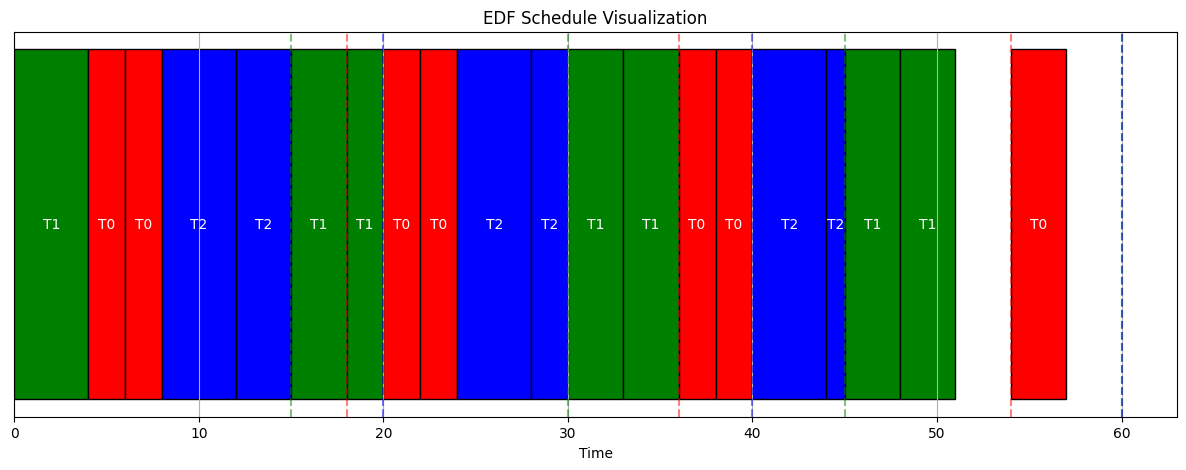


Job Execution Details:
Time | Task | Execution | Deadline
-----|------|-----------|---------
   0-4    | T1   |    4/4    | 15     
   4-6    | T0   |    2/3    | 18     
   6-8    | T0   |    4/3    | 18     
   8-12   | T2   |    4/5    | 20     
  12-15   | T2   |    7/5    | 20     
  15-18   | T1   |    3/4    | 30     
  18-20   | T1   |    5/4    | 30     
  20-22   | T0   |    2/3    | 36     
  22-24   | T0   |    4/3    | 36     
  24-28   | T2   |    4/5    | 40     
  28-30   | T2   |    6/5    | 40     
  30-33   | T1   |    3/4    | 45     
  33-36   | T1   |    6/4    | 45     
  36-38   | T0   |    2/3    | 54     
  38-40   | T0   |    4/3    | 54     
  40-44   | T2   |    4/5    | 60     
  44-45   | T2   |    5/5    | 60     
  45-48   | T1   |    3/4    | 60     
  48-51   | T1   |    6/4    | 60     
  54-57   | T0   |    3/3    | 72     

Task Metrics:
Task | Period | WCET | NET | Jobs | Missed | Max Response
-----|--------|------|-----|------|--------|---------

In [2]:
# test_edf.py
import heapq
import matplotlib.pyplot as plt
from EDF import Scheduler, Task, Job  # Replace 'your_original_file' with the actual filename

def test_edf_scheduling():
    # Create a simple test scenario with 1 core and 3 tasks
    scheduler = Scheduler(
        num_cores=1,
        scheduling_policy='EDF',
        allocation_policy='partitioned_best_fit',
        is_preemptive=True
    )
    
    # Manually create tasks with different periods and WCETs
    tasks = [
        Task(id=0, period=18, wcet=3, net=2, utilization=0.3),  # 3/10 = 0.3
        Task(id=1, period=15, wcet=4, net=3, utilization=0.267),  # 4/15 ≈ 0.267
        Task(id=2, period=20, wcet=5, net=4, utilization=0.25)   # 5/20 = 0.25
    ]
    
    # Allocate tasks to core (since we're testing partitioned)
    scheduler.cores[0].tasks = tasks.copy()
    for task in tasks:
        task.core_assignment = 0
    
    # Simulate for 60 time units (enough to see several periods)
    max_time = 60
    scheduler._simulate_core_edf(scheduler.cores[0], max_time)
    
    # Collect and visualize the schedule
    schedule = scheduler.cores[0].schedule
    task_colors = {0: 'red', 1: 'green', 2: 'blue'}
    
    # Create a timeline visualization
    plt.figure(figsize=(15, 5))
    
    # Plot each job execution
    for start, end, task_id, _ in schedule:
        plt.barh(y=0, width=end-start, left=start, color=task_colors[task_id], edgecolor='black')
        plt.text((start+end)/2, 0, f'T{task_id}', ha='center', va='center', color='white')
    
    # Mark deadlines for each task
    for task in tasks:
        deadlines = range(task.period, max_time + task.period, task.period)
        for d in deadlines:
            if d <= max_time:
                plt.axvline(x=d, color=task_colors[task.id], linestyle='--', alpha=0.5)
    
    plt.yticks([])
    plt.xlabel('Time')
    plt.title('EDF Schedule Visualization')
    plt.grid(True, axis='x')
    plt.show()
    
    # Print job execution details
    print("\nJob Execution Details:")
    print("Time | Task | Execution | Deadline")
    print("-----|------|-----------|---------")
    for start, end, task_id, exec_time in schedule:
        task = tasks[task_id]
        job_deadline = start - (start % task.period) + task.period
        print(f"{start:4}-{end:<4} | T{task_id}   | {exec_time:4}/{task.wcet:<4} | {job_deadline:<7}")
    
    # Print task metrics
    print("\nTask Metrics:")
    print("Task | Period | WCET | NET | Jobs | Missed | Max Response")
    print("-----|--------|------|-----|------|--------|-------------")
    for task in tasks:
        print(f"T{task.id:<4} | {task.period:<6} | {task.wcet:<4} | {task.net:<3} | {task.total_jobs:<4} | {task.missed_deadlines:<6} | {task.max_response:<11}")
    
    # Verify EDF properties
    verify_edf_properties(schedule, tasks, max_time)

def verify_edf_properties(schedule, tasks, max_time):
    print("\nVerifying EDF Properties:")
    
    # 1. Check that jobs are scheduled in deadline order
    deadlines = []
    current_job = None
    prev_deadline = -1
    violations = 0
    
    for start, end, task_id, _ in schedule:
        task = tasks[task_id]
        # Calculate absolute deadline for this job
        job_release = start - (start % task.period)
        job_deadline = job_release + task.period
        
        if current_job is None or task_id != current_job:
            deadlines.append((job_deadline, task_id, start))
            current_job = task_id
        
        # Check if this deadline is earlier than previous
        if job_deadline < prev_deadline and prev_deadline != -1:
            violations += 1
            print(f"Warning: EDF violation at time {start} - T{task_id} (deadline {job_deadline}) scheduled after job with deadline {prev_deadline}")
        
        prev_deadline = job_deadline
    
    if violations == 0:
        print("1. No EDF priority violations found - jobs always scheduled in deadline order")
    else:
        print(f"1. Found {violations} EDF priority violations")
    
    # 2. Check that no deadlines are missed when utilization <= 1
    total_utilization = sum(task.wcet / task.period for task in tasks)
    missed_deadlines = sum(task.missed_deadlines for task in tasks)
    
    print(f"\n2. Utilization Check: Total utilization = {total_utilization:.2f}")
    if total_utilization <= 1.0:
        if missed_deadlines == 0:
            print(" - No deadlines missed as expected (utilization ≤ 1)")
        else:
            print(f" - Unexpected: {missed_deadlines} deadlines missed despite utilization ≤ 1")
    else:
        print(f" - Utilization > 1, {missed_deadlines} deadlines missed (may be expected)")
    
    # 3. Check response times
    print("\n3. Response Time Analysis:")
    for task in tasks:
        expected_max_response = task.period  # For tasks with utilization ≤ 1
        print(f"T{task.id}: Max response = {task.max_response} (period = {task.period})", end=" ")
        if task.max_response <= expected_max_response:
            print("✓ Within expected bound")
        else:
            print("✗ Exceeds period!")

def visualize_heap_operations():
    """Visualize how the heap works in EDF scheduling"""
    print("\nVisualizing EDF Heap Operations:")
    
    # Create some jobs with different deadlines
    jobs = [
        Job(Task(id=0, period=10, wcet=2, net=1, utilization=0.2), 0),
        Job(Task(id=1, period=15, wcet=3, net=2, utilization=0.2), 0),
        Job(Task(id=2, period=20, wcet=4, net=3, utilization=0.2), 0),
        Job(Task(id=0, period=10, wcet=2, net=1, utilization=0.2), 10),
        Job(Task(id=1, period=15, wcet=3, net=2, utilization=0.2), 15)
    ]
    
    # Manually set deadlines (normally done in Job.__init__)
    for job in jobs:
        job.deadline = job.release_time + job.task.period
    
    print("\nInitial Jobs (unordered):")
    for i, job in enumerate(jobs):
        print(f"Job {i}: Task {job.task.id}, Release={job.release_time}, Deadline={job.deadline}")
    
    # Create a heap
    heap = []
    for job in jobs:
        heapq.heappush(heap, job)
    
    print("\nHeap Order (after push operations):")
    print("This shows the order jobs would be popped based on deadlines:")
    for i, job in enumerate(heap):
        print(f"Heap[{i}]: Task {job.task.id}, Deadline={job.deadline}")
    
    print("\nPopping jobs from heap (should be in deadline order):")
    while heap:
        job = heapq.heappop(heap)
        print(f"Popped: Task {job.task.id}, Deadline={job.deadline}")

if __name__ == "__main__":
    # Run the tests
    test_edf_scheduling()
    visualize_heap_operations()


=== Testing Multicore EDF Scheduling (4 cores, 8 tasks) ===

Task Allocation to Cores:
Core 0: Tasks [0, 1, 2, 3], Utilization: 0.89
Core 1: Tasks [4, 5, 6, 7], Utilization: 0.58
Core 2: Tasks [], Utilization: 0.00
Core 3: Tasks [], Utilization: 0.00


C:\Users\mi\AppData\Local\Temp\ipykernel_51736\3049098239.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(scheduler.cores[0].tasks))


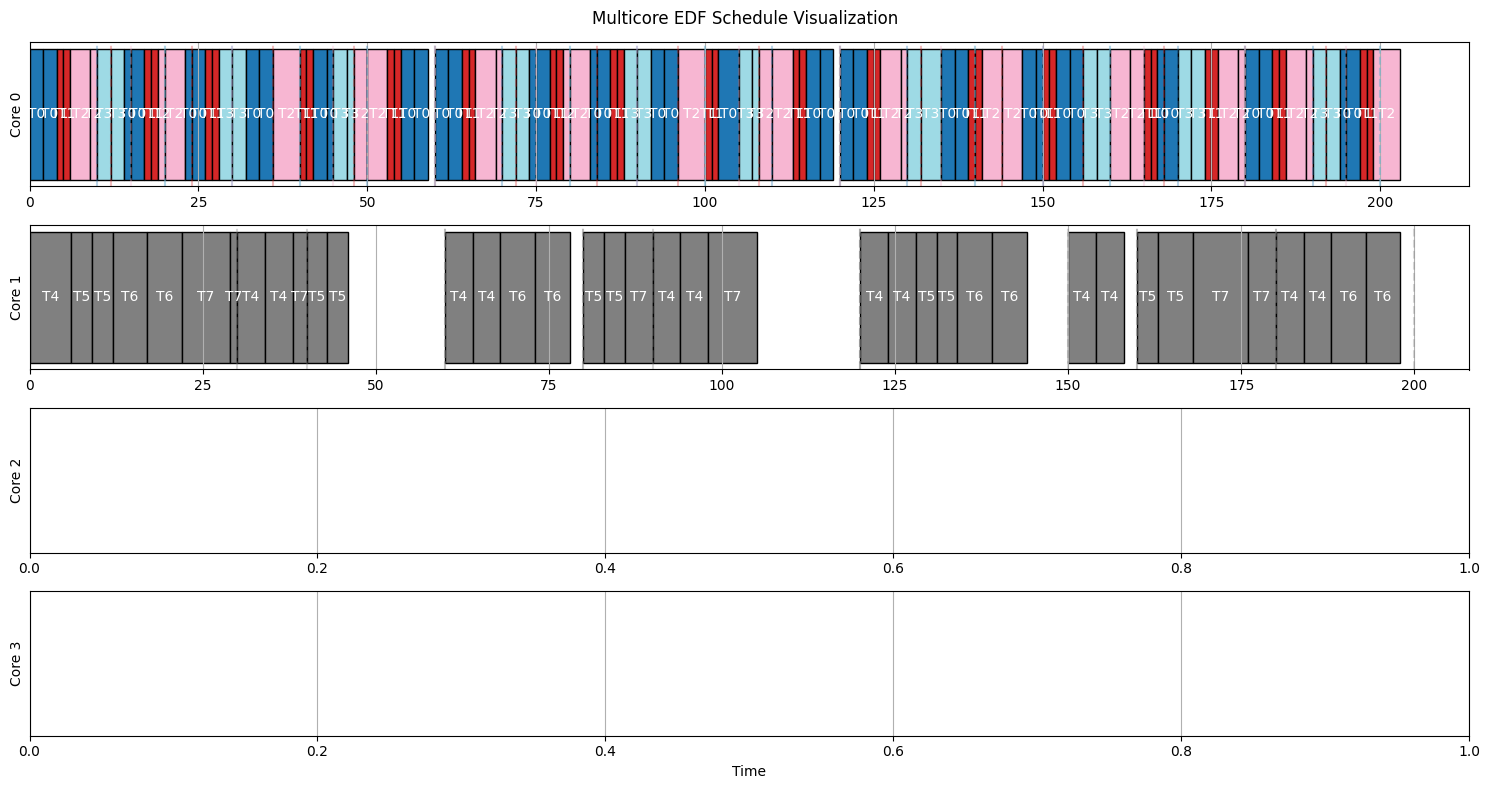


=== Multicore Scheduling Results ===

Core Statistics:
Core | Tasks | Planned Util | Actual Util | Missed Deadlines
-----|-------|--------------|-------------|-----------------
   0 |     4 |         0.89 |        1.00 |               0
   1 |     4 |         0.58 |        0.80 |               0
   2 |     0 |         0.00 |        0.00 |               0
   3 |     0 |         0.00 |        0.00 |               0

Task Statistics (Tasks with missed deadlines):
Task | Core | Period | WCET | NET | Jobs | Missed | Max Response
-----|------|--------|------|-----|------|--------|-------------

Verifying EDF Properties per Core:

Core 0:
✓ No EDF priority violations
Core utilization: 0.88
✓ Utilization ≤ 1.0 - all deadlines should be met

Core 1:
✗ 4 EDF priority violations
Core utilization: 0.58
✓ Utilization ≤ 1.0 - all deadlines should be met

Core 2:
No jobs scheduled on this core

Core 3:
No jobs scheduled on this core

=== Testing Global EDF Scheduling (2 cores, 4 tasks) ===


C:\Users\mi\AppData\Local\Temp\ipykernel_51736\3049098239.py:192: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(scheduler.cores[0].tasks))


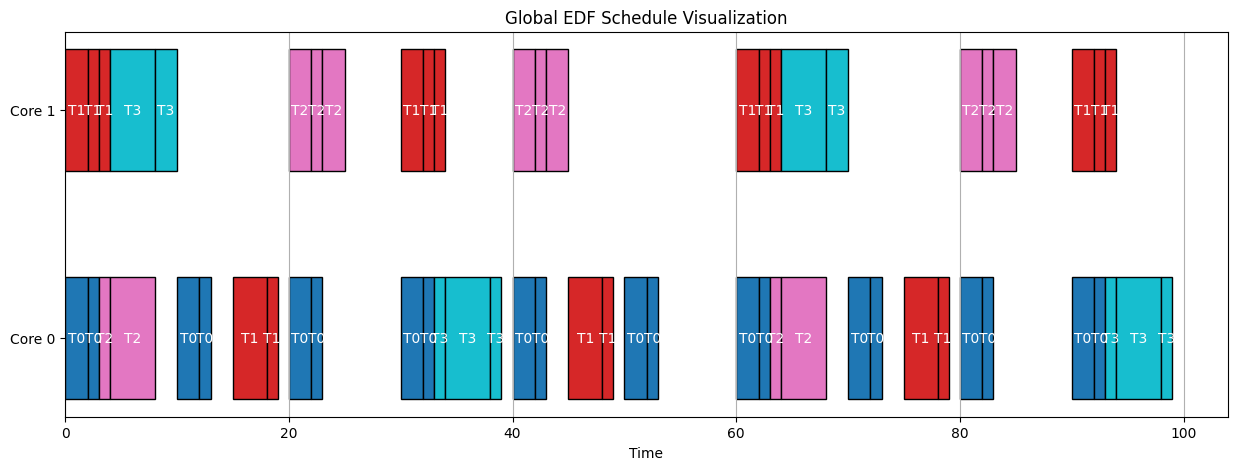


=== Global EDF Results ===
Total System Utilization: 1.02
Total Missed Deadlines: 0
✓ System within theoretical schedulability bound

Task Migration Counts:
Task 0: 19 migrations
Task 2: 12 migrations
Task 1: 17 migrations
Task 3: 9 migrations


In [1]:
# test_multicore_edf.py
import heapq
import matplotlib.pyplot as plt
from collections import defaultdict
from EDF import Scheduler, Task, Job  # Replace with your actual filename

def test_multicore_edf():
    # Create a test scenario with 4 cores and 8 tasks
    print("\n=== Testing Multicore EDF Scheduling (4 cores, 8 tasks) ===")
    scheduler = Scheduler(
        num_cores=4,
        scheduling_policy='EDF',
        allocation_policy='partitioned_best_fit',
        is_preemptive=True
    )
    
    # Create tasks with different characteristics
    tasks = [
        # High priority (short period) tasks
        Task(id=0, period=10, wcet=3, net=2, utilization=0.3),
        Task(id=1, period=12, wcet=2, net=1, utilization=0.17),
        Task(id=2, period=15, wcet=4, net=3, utilization=0.27),
        Task(id=3, period=20, wcet=3, net=2, utilization=0.15),
        
        # Medium priority tasks
        Task(id=4, period=30, wcet=6, net=4, utilization=0.2),
        Task(id=5, period=40, wcet=5, net=3, utilization=0.125),
        
        # Low priority (long period) tasks
        Task(id=6, period=60, wcet=8, net=5, utilization=0.13),
        Task(id=7, period=80, wcet=10, net=7, utilization=0.125)
    ]
    
    # Allocate tasks to cores using the specified policy
    scheduler.allocate_tasks(tasks)
    
    # Print task allocation
    print("\nTask Allocation to Cores:")
    for core in scheduler.cores:
        print(f"Core {core.id}: Tasks {[t.id for t in core.tasks]}, "
            f"Utilization: {sum(t.utilization for t in core.tasks):.2f}")
    
    # Simulate for 200 time units
    max_time = 200
    scheduler.simulate(tasks, max_time)
    
    # Visualize each core's schedule
    visualize_multicore_schedule(scheduler, max_time)
    
    # Analyze and print results
    analyze_multicore_results(scheduler, tasks, max_time)

def visualize_multicore_schedule(scheduler, max_time):
    """Create a Gantt chart showing the schedule on each core"""
    plt.figure(figsize=(15, 8))
    
    # Create a color map for tasks
    colors = plt.cm.get_cmap('tab20', len(scheduler.cores[0].tasks))
    task_colors = {task.id: colors(i) for i, task in enumerate(scheduler.cores[0].tasks)}
    
    for i, core in enumerate(scheduler.cores):
        plt.subplot(len(scheduler.cores), 1, i+1)
        
        # Plot each job execution
        for start, end, task_id, _ in core.schedule:
            plt.barh(y=0, width=end-start, left=start, 
                    color=task_colors.get(task_id, 'gray'), 
                    edgecolor='black')
            plt.text((start+end)/2, 0, f'T{task_id}', 
                    ha='center', va='center', color='white')
        
        # Mark deadlines for each task
        for task in core.tasks:
            deadlines = range(task.period, max_time + task.period, task.period)
            for d in deadlines:
                if d <= max_time:
                    plt.axvline(x=d, color=task_colors.get(task.id, 'gray'), 
                            linestyle='--', alpha=0.3)
        
        plt.yticks([])
        plt.ylabel(f'Core {core.id}')
        plt.grid(True, axis='x')
    
    plt.xlabel('Time')
    plt.suptitle('Multicore EDF Schedule Visualization')
    plt.tight_layout()
    plt.show()

def analyze_multicore_results(scheduler, tasks, max_time):
    """Analyze and print scheduling results"""
    print("\n=== Multicore Scheduling Results ===")
    
    # Core statistics
    print("\nCore Statistics:")
    print("Core | Tasks | Planned Util | Actual Util | Missed Deadlines")
    print("-----|-------|--------------|-------------|-----------------")
    for core in scheduler.cores:
        core_tasks = [t for t in tasks if t.core_assignment == core.id]
        missed = sum(t.missed_deadlines for t in core_tasks)
        print(f"{core.id:4} | {len(core.tasks):5} | {core.utilization:12.2f} | "
              f"{core.actual_utilization:11.2f} | {missed:15}")
    
    # Task statistics
    print("\nTask Statistics (Tasks with missed deadlines):")
    print("Task | Core | Period | WCET | NET | Jobs | Missed | Max Response")
    print("-----|------|--------|------|-----|------|--------|-------------")
    for task in sorted(tasks, key=lambda x: x.core_assignment):
        if task.missed_deadlines > 0:
            print(f"T{task.id:4} | {task.core_assignment:4} | {task.period:6} | "
                  f"{task.wcet:4} | {task.net:3} | {task.total_jobs:4} | "
                  f"{task.missed_deadlines:6} | {task.max_response:11}")
    
    # Verify EDF properties per core
    print("\nVerifying EDF Properties per Core:")
    for core in scheduler.cores:
        print(f"\nCore {core.id}:")
        verify_core_schedule(core.schedule, core.tasks, max_time)

def verify_core_schedule(schedule, tasks, max_time):
    """Verify EDF properties for a single core's schedule"""
    if not schedule:
        print("No jobs scheduled on this core")
        return
    
    # Create a task lookup dictionary
    task_dict = {task.id: task for task in tasks}
    
    # 1. Check deadline ordering
    prev_deadline = -1
    violations = 0
    current_job = None
    
    for start, end, task_id, _ in schedule:
        task = task_dict[task_id]
        job_release = start - (start % task.period)
        job_deadline = job_release + task.period
        
        if current_job is None or task_id != current_job:
            if job_deadline < prev_deadline and prev_deadline != -1:
                violations += 1
            current_job = task_id
            prev_deadline = job_deadline
    
    if violations == 0:
        print("✓ No EDF priority violations")
    else:
        print(f"✗ {violations} EDF priority violations")
    
    # 2. Check utilization bounds
    core_utilization = sum(task.wcet/task.period for task in tasks)
    print(f"Core utilization: {core_utilization:.2f}")
    if core_utilization > 1.0:
        print("✗ Utilization exceeds 1.0 - deadline misses expected")
    else:
        print("✓ Utilization ≤ 1.0 - all deadlines should be met")

def test_global_edf():
    """Test global EDF scheduling"""
    print("\n=== Testing Global EDF Scheduling (2 cores, 4 tasks) ===")
    scheduler = Scheduler(
        num_cores=2,
        scheduling_policy='EDF',
        allocation_policy='global',
        is_preemptive=True
    )
    
    tasks = [
        Task(id=0, period=10, wcet=3, net=2, utilization=0.3),
        Task(id=1, period=15, wcet=4, net=3, utilization=0.27),
        Task(id=2, period=20, wcet=5, net=4, utilization=0.25),
        Task(id=3, period=30, wcet=6, net=4, utilization=0.2)
    ]
    
    # For global scheduling, tasks aren't assigned to specific cores initially
    scheduler.allocate_tasks(tasks)
    
    # Simulate for 100 time units
    max_time = 100
    scheduler.simulate(tasks, max_time)
    
    # Visualize the schedule
    visualize_global_schedule(scheduler, max_time)
    
    # Analyze results
    analyze_global_results(scheduler, tasks, max_time)

def visualize_global_schedule(scheduler, max_time):
    """Visualize global EDF schedule across cores"""
    plt.figure(figsize=(15, 5))
    
    # Create a color map for tasks
    colors = plt.cm.get_cmap('tab10', len(scheduler.cores[0].tasks))
    task_colors = {task.id: colors(i) for i, task in enumerate(scheduler.cores[0].tasks)}
    
    for core in scheduler.cores:
        y_offset = core.id * 1.5
        for start, end, task_id, _ in core.schedule:
            plt.barh(y=y_offset, width=end-start, left=start, 
                    color=task_colors[task_id], edgecolor='black')
            plt.text((start+end)/2, y_offset, f'T{task_id}', 
                    ha='center', va='center', color='white')
    
    plt.yticks([i * 1.5 for i in range(len(scheduler.cores))], 
               [f'Core {i}' for i in range(len(scheduler.cores))])
    plt.xlabel('Time')
    plt.title('Global EDF Schedule Visualization')
    plt.grid(True, axis='x')
    plt.show()

def analyze_global_results(scheduler, tasks, max_time):
    """Analyze global EDF scheduling results"""
    print("\n=== Global EDF Results ===")
    
    # System-wide statistics
    total_util = sum(t.wcet/t.period for t in tasks)
    total_missed = sum(t.missed_deadlines for t in tasks)
    print(f"Total System Utilization: {total_util:.2f}")
    print(f"Total Missed Deadlines: {total_missed}")
    
    # Check theoretical bounds
    m = scheduler.num_cores
    if total_util > m:
        print("✗ Total utilization exceeds m cores - deadline misses expected")
    elif total_util > m - (m-1) * max(t.utilization for t in tasks):
        print("⚠ System in potentially unschedulable region")
    else:
        print("✓ System within theoretical schedulability bound")

if __name__ == "__main__":
    # Run the multicore partitioned EDF test
    test_multicore_edf()
    
    # Run the global EDF test
    test_global_edf()